In [1]:
import pandas as pd 
import numpy as np 
import yfinance as yf 
import matplotlib.pyplot as plt 
from arch import arch_model

plt.style.use('bmh')

In [2]:
assets = ['GOOG', 'MSFT', 'AAPL']
N = len(assets)

data = yf.download(assets, period='5y', interval='1d', auto_adjust=True)
# returns in percentage (%)
returns = 100 * np.log(data.Close / data.Close.shift(1)).dropna()
returns

[*********************100%***********************]  3 of 3 completed


,AAPL,GOOG,MSFT
Date,,,
2017-03-17,-0.498807,0.392730,0.355174
2017-03-20,1.044630,-0.437510,0.092435
2017-03-21,-1.151832,-2.137246,-1.115072
2017-03-22,1.123553,-0.104816,1.268980
2017-03-23,-0.354192,-1.458286,-0.246342
...,...,...,...
2022-03-09,3.439894,5.046170,4.483782
2022-03-10,-2.756259,-0.888408,-1.013788
2022-03-11,-2.419916,-1.676977,-1.951760


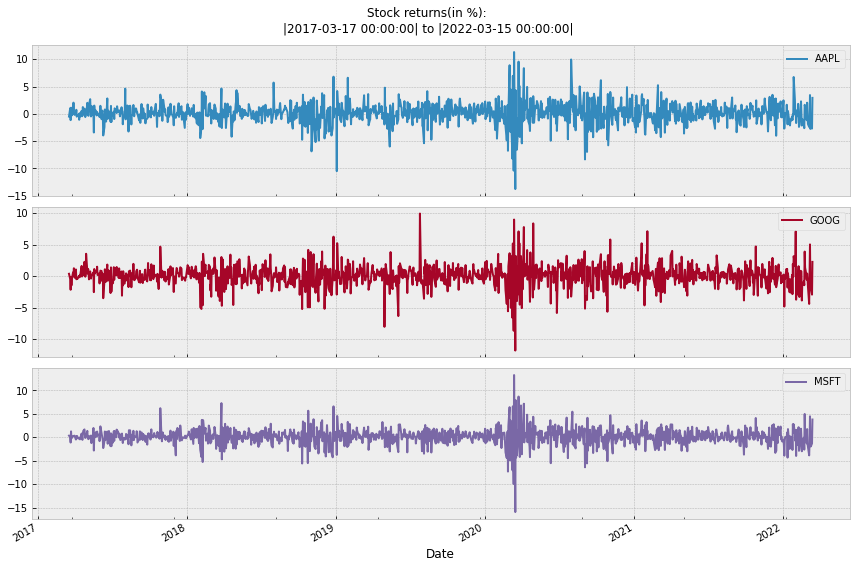

In [3]:
returns.plot(subplots=True, figsize=(12,8), 
             title=f'Stock returns(in %): \n|{returns.index[0]}| to |{returns.index[-1]}|')
plt.tight_layout()
plt.show()

In [4]:
%load_ext rpy2.ipython

In [5]:
# %%R
# # install rmgarch 
# # run if not yet installed

# install.packages('rmgarch')

In [6]:
%%R -i returns
print(head(returns))

                          AAPL       GOOG        MSFT
2017-03-17 00:00:00 -0.4988067  0.3927297  0.35517450
2017-03-20 00:00:00  1.0446298 -0.4375105  0.09243454
2017-03-21 00:00:00 -1.1518324 -2.1372461 -1.11507205
2017-03-22 00:00:00  1.1235525 -0.1048155  1.26897980
2017-03-23 00:00:00 -0.3541920 -1.4582857 -0.24634228
2017-03-24 00:00:00 -0.1988872 -0.3860305  0.16942745


In [7]:
%%R
library(rmgarch)

R[write to console]: Loading required package: rugarch

R[write to console]: Loading required package: parallel

R[write to console]: 
Attaching package: ‘rugarch’


R[write to console]: The following object is masked from ‘package:stats’:

    sigma




In [8]:
%%R
# define GARCH(1,1)
univariate_spec <- ugarchspec(
    mean.model = list(armaOrder = c(0,0)),
    variance.model = list(garchOrder = c(1,1), model="sGARCH"),
    distribution.model = "norm"
)

# define DCC(1,1)
n <- dim(returns)[2]
dcc_spec <- dccspec(
    uspec = multispec(replicate(n, univariate_spec)),
    dccOrder = c(1,1),
    distribution = "mvnorm"
)

In [9]:
%%R
dcc_fit <- dccfit(dcc_spec, data=returns)
dcc_fit


*---------------------------------*
*          DCC GARCH Fit          *
*---------------------------------*

Distribution         :  mvnorm
Model                :  DCC(1,1)
No. Parameters       :  17
[VAR GARCH DCC UncQ] : [0+12+2+3]
No. Series           :  3
No. Obs.             :  1258
Log-Likelihood       :  -6290.263
Av.Log-Likelihood    :  -5 

Optimal Parameters
-----------------------------------
               Estimate  Std. Error  t value Pr(>|t|)
[AAPL].mu      0.200067    0.046393   4.3125 0.000016
[AAPL].omega   0.160757    0.049045   3.2778 0.001046
[AAPL].alpha1  0.139106    0.027617   5.0370 0.000000
[AAPL].beta1   0.820712    0.029996  27.3610 0.000000
[GOOG].mu      0.120527    0.046990   2.5650 0.010319
[GOOG].omega   0.174585    0.113824   1.5338 0.125075
[GOOG].alpha1  0.082896    0.029640   2.7968 0.005161
[GOOG].beta1   0.857394    0.061064  14.0409 0.000000
[MSFT].mu      0.165271    0.035071   4.7125 0.000002
[MSFT].omega   0.170931    0.064944   2.6320 0.00848

In [10]:
%%R
forecasts <- dccforecast(dcc_fit, n.ahead = 5)

In [11]:
%%R
H = forecasts@mforecast$H
H = H[[1]]
H

, , 1

         [,1]     [,2]     [,3]
[1,] 5.747540 3.646274 4.281104
[2,] 3.646274 4.875813 4.227218
[3,] 4.281104 4.227218 6.224725

, , 2

         [,1]     [,2]     [,3]
[1,] 5.677351 3.480059 4.091920
[2,] 3.480059 4.759260 4.050265
[3,] 4.091920 4.050265 6.036735

, , 3

         [,1]     [,2]     [,3]
[1,] 5.609982 3.339534 3.929600
[2,] 3.339534 4.649666 3.894871
[3,] 3.929600 3.894871 5.859585

, , 4

         [,1]     [,2]     [,3]
[1,] 5.545319 3.219782 3.789104
[2,] 3.219782 4.546617 3.757316
[3,] 3.789104 3.757316 5.692649

, , 5

         [,1]     [,2]     [,3]
[1,] 5.483255 3.116902 3.666434
[2,] 3.116902 4.449720 3.634641
[3,] 3.666434 3.634641 5.535338



In [12]:
%R -o H

In [13]:
H.T

array([[[5.74754036, 3.64627372, 4.28110359],
        [3.64627372, 4.87581253, 4.22721767],
        [4.28110359, 4.22721767, 6.22472496]],

       [[5.67735081, 3.48005865, 4.09191954],
        [3.48005865, 4.75925959, 4.05026467],
        [4.09191954, 4.05026467, 6.03673493]],

       [[5.6099816 , 3.33953403, 3.92960045],
        [3.33953403, 4.64966612, 3.89487084],
        [3.92960045, 3.89487084, 5.8595845 ]],

       [[5.54531942, 3.2197825 , 3.78910417],
        [3.2197825 , 4.54661653, 3.75731587],
        [3.78910417, 3.75731587, 5.69264867]],

       [[5.48325548, 3.11690199, 3.66643397],
        [3.11690199, 4.44972011, 3.63464138],
        [3.66643397, 3.63464138, 5.53533846]]])